[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1SW8W5wWs4UueZt-W44_kxC3-sGbYnP_d?usp=sharing)


In [2]:
# Import libraries
import gdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.cluster.hierarchy import dendrogram
from matplotlib import cm
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold, mutual_info_regression, chi2, f_classif
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, silhouette_samples
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.utils import resample
from joblib import Parallel, delayed
import warnings
import time

In [3]:
# Download dataset
file_id = '1au6HqbGWpBCszFFBjZ4YmdpnqhThnTlU'
url = f'https://drive.google.com/uc?export=download&id={file_id}'
gdown.download(url, 'dataset.csv', quiet=False)

# Load data with error handling
try:
    df = pd.read_csv('dataset.csv', encoding='latin1')
except Exception as e:
    print(f"Error loading file: {e}")
    # Try alternative encodings if needed
    try:
        df = pd.read_csv('dataset.csv', encoding='ISO-8859-1')
    except:
        df = pd.read_csv('dataset.csv', encoding='utf-8', errors='ignore')

# Enhanced data inspection
def inspect_data(df):
    print("=== DATA INSPECTION ===")
    print(f"Shape: {df.shape}")
    print("\nData Types:")
    print(df.dtypes.value_counts())

    print("\nMissing Values Summary:")
    missing = df.isnull().sum()
    print(missing[missing > 0])

    print("\nDuplicate Rows:", df.duplicated().sum())

    numeric_cols = df.select_dtypes(include=np.number).columns
    if len(numeric_cols) > 0:
        print("\nNumeric Columns Statistics:")
        print(df[numeric_cols].describe().T)

    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(cat_cols) > 0:
        print("\nCategorical Columns Summary:")
        for col in cat_cols:
            print(f"\n{col}:")
            print(df[col].value_counts(dropna=False).head())

inspect_data(df)

# Advanced cleaning function
def clean_data(df, outlier_threshold=1.5):
    # Make a copy
    clean_df = df.copy()

    # Handle missing values
    num_imputer = SimpleImputer(strategy='median')
    cat_imputer = SimpleImputer(strategy='most_frequent')

    numeric_cols = clean_df.select_dtypes(include=np.number).columns
    if len(numeric_cols) > 0:
        clean_df[numeric_cols] = num_imputer.fit_transform(clean_df[numeric_cols])

    cat_cols = clean_df.select_dtypes(include=['object']).columns
    if len(cat_cols) > 0:
        clean_df[cat_cols] = cat_imputer.fit_transform(clean_df[cat_cols])

    # Handle outliers using IQR method
    for col in numeric_cols:
        q1 = clean_df[col].quantile(0.25)
        q3 = clean_df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - outlier_threshold * iqr
        upper = q3 + outlier_threshold * iqr
        clean_df[col] = np.where(clean_df[col] < lower, lower,
                                np.where(clean_df[col] > upper, upper, clean_df[col]))

    # Remove duplicates
    clean_df = clean_df.drop_duplicates()

    # Convert object types to category for memory efficiency
    for col in cat_cols:
        clean_df[col] = clean_df[col].astype('category')

    return clean_df

cleaned_df = clean_data(df)
print("\nData cleaning completed. New shape:", cleaned_df.shape)


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1au6HqbGWpBCszFFBjZ4YmdpnqhThnTlU
From (redirected): https://drive.google.com/uc?export=download&id=1au6HqbGWpBCszFFBjZ4YmdpnqhThnTlU&confirm=t&uuid=273a78a9-c7b1-4845-9722-00a19c345bff
To: /content/dataset.csv
100%|██████████| 151M/151M [00:02<00:00, 50.8MB/s]


=== DATA INSPECTION ===
Shape: (284807, 31)

Data Types:
float64    30
int64       1
Name: count, dtype: int64

Missing Values Summary:
Series([], dtype: int64)

Duplicate Rows: 1081

Numeric Columns Statistics:
           count          mean           std         min           25%  \
Time    284807.0  9.481386e+04  47488.145955    0.000000  54201.500000   
V1      284807.0  1.168375e-15      1.958696  -56.407510     -0.920373   
V2      284807.0  3.416908e-16      1.651309  -72.715728     -0.598550   
V3      284807.0 -1.379537e-15      1.516255  -48.325589     -0.890365   
V4      284807.0  2.074095e-15      1.415869   -5.683171     -0.848640   
V5      284807.0  9.604066e-16      1.380247 -113.743307     -0.691597   
V6      284807.0  1.487313e-15      1.332271  -26.160506     -0.768296   
V7      284807.0 -5.556467e-16      1.237094  -43.557242     -0.554076   
V8      284807.0  1.213481e-16      1.194353  -73.216718     -0.208630   
V9      284807.0 -2.406331e-15      1.098632  -1

In [ ]:
print(cleaned_df.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


# feature selection





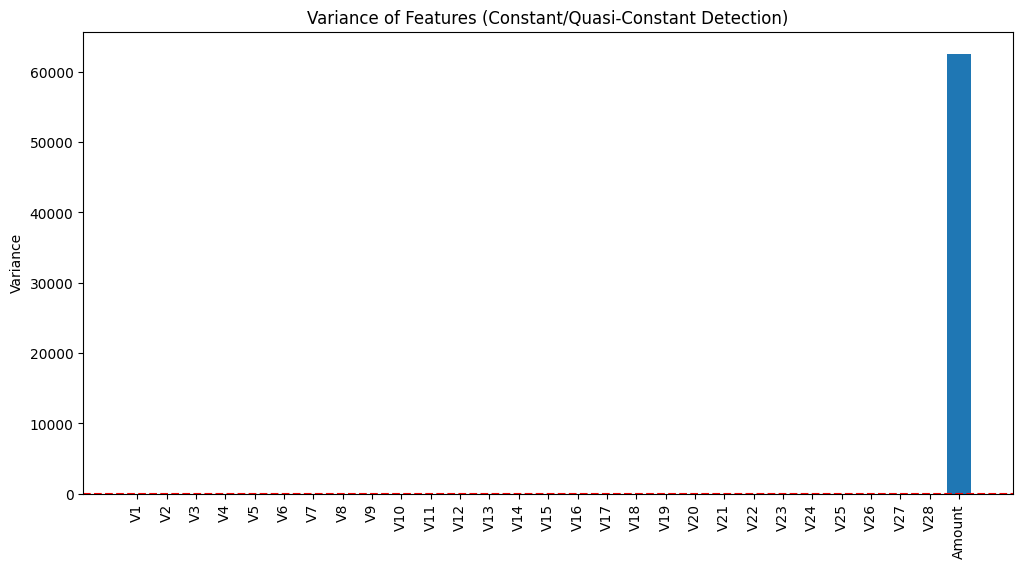

In [ ]:
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt

# Asumsikan df adalah DataFrame Anda
constant_filter = VarianceThreshold(threshold=0.01)  # Threshold untuk quasi-constant
constant_filter.fit(df.drop(['Time', 'Class'], axis=1))

# Visualisasi variance tiap feature
variances = constant_filter.variances_
plt.figure(figsize=(12, 6))
plt.bar(df.drop(['Time', 'Class'], axis=1).columns, variances)
plt.axhline(y=0.01, color='r', linestyle='--')
plt.xticks(rotation=90)
plt.title('Variance of Features (Constant/Quasi-Constant Detection)')
plt.ylabel('Variance')
plt.show()


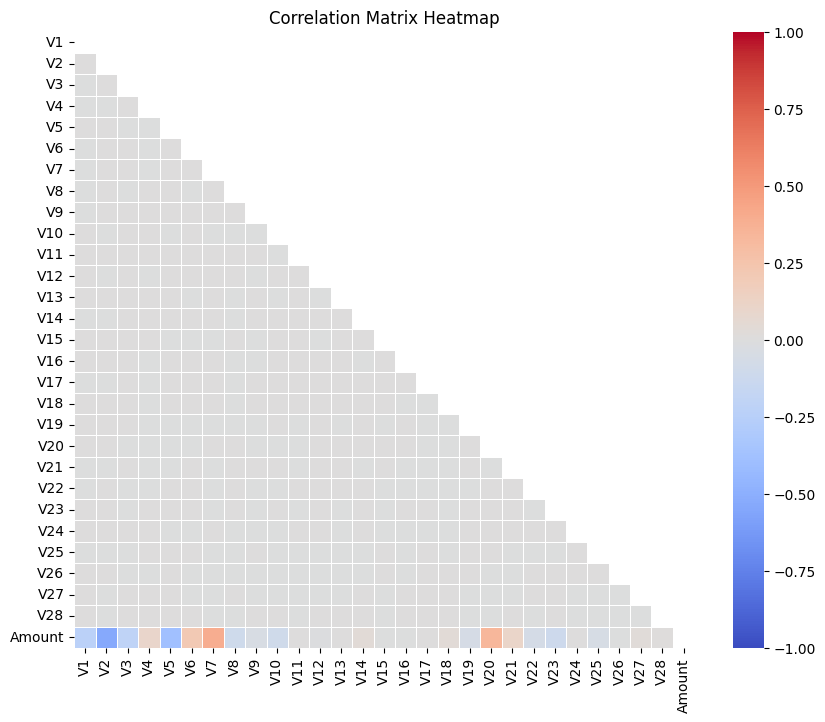

In [ ]:
#correlation
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 8))
corr_matrix = df.drop(['Time', 'Class'], axis=1).corr()

# Mask untuk segitiga atas
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm',
            vmin=-1, vmax=1, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

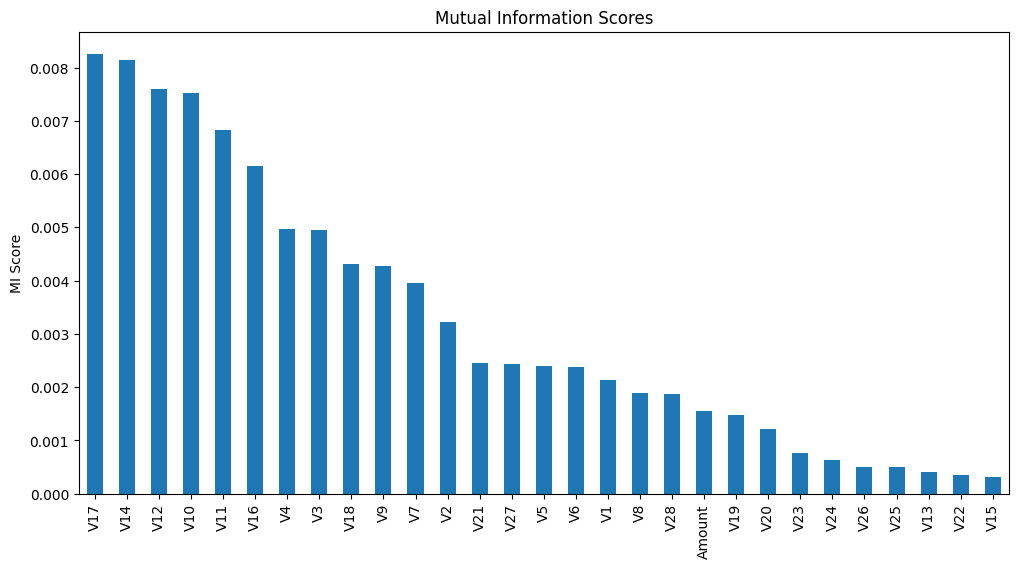

In [ ]:
from sklearn.feature_selection import mutual_info_classif

X = df.drop(['Time', 'Class'], axis=1)
y = df['Class']

mi = mutual_info_classif(X, y, random_state=42)
mi_series = pd.Series(mi, index=X.columns)
mi_series.sort_values(ascending=False).plot.bar(figsize=(12, 6))
plt.title('Mutual Information Scores')
plt.ylabel('MI Score')
plt.show()

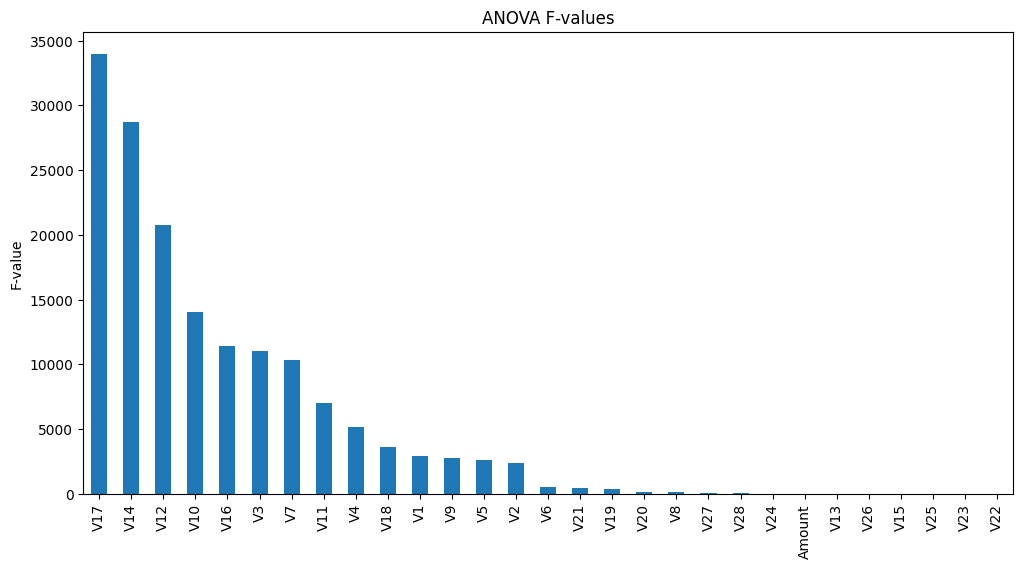

In [ ]:
#anova
from sklearn.feature_selection import f_classif

f_scores, p_values = f_classif(X, y)
f_series = pd.Series(f_scores, index=X.columns)
f_series.sort_values(ascending=False).plot.bar(figsize=(12, 6))
plt.title('ANOVA F-values')
plt.ylabel('F-value')
plt.show()

<Figure size 1600x800 with 0 Axes>

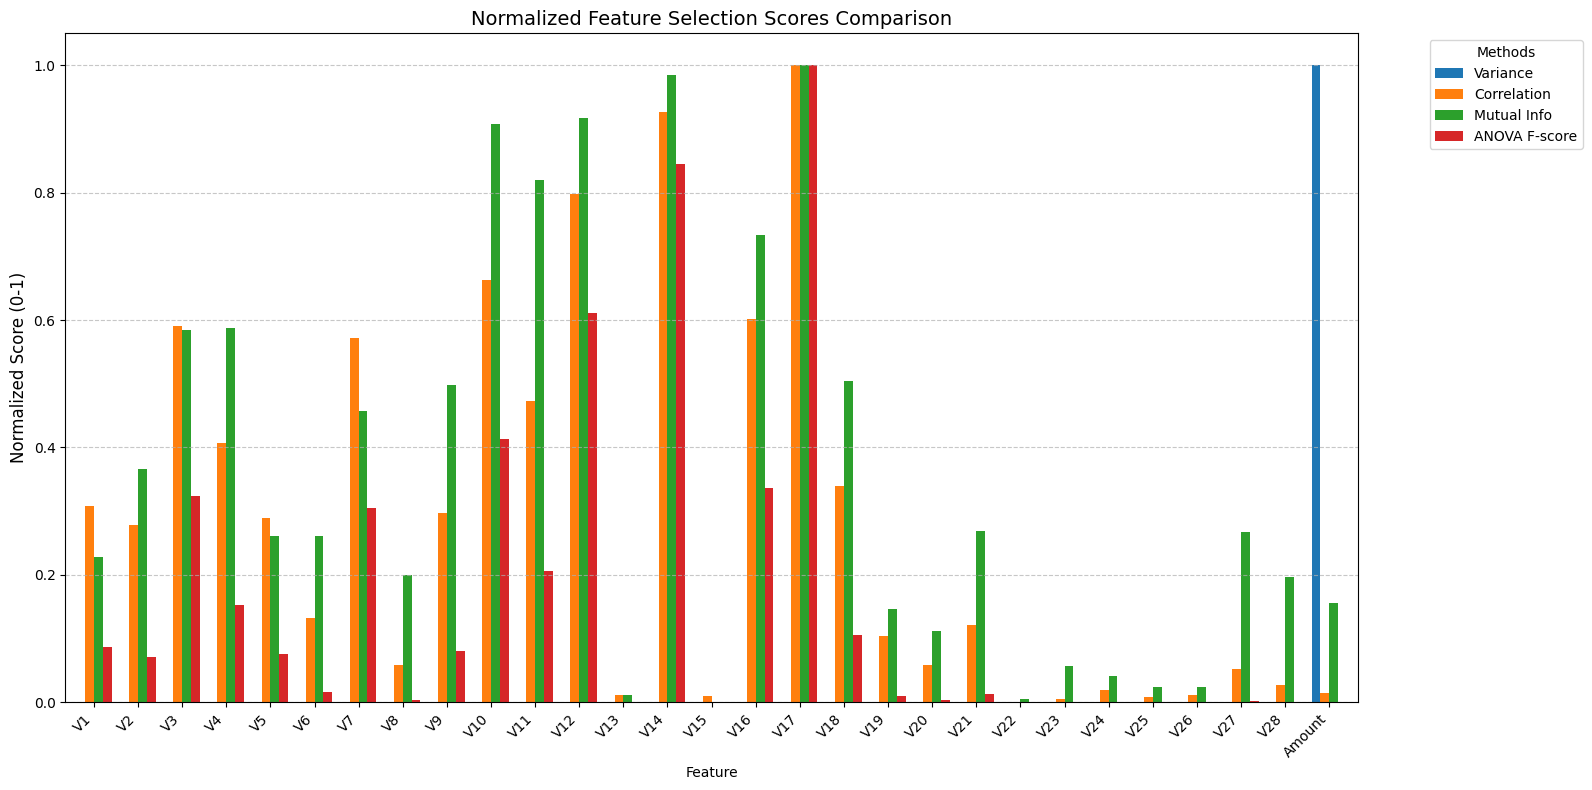

In [ ]:
#Perbandingan Metode Feature Selection
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, f_classif

# Persiapan data
X = df.drop(['Time', 'Class'], axis=1)
y = df['Class']

# 1. Constant/Quasi-Constant Detection
constant_filter = VarianceThreshold(threshold=0.01)
constant_filter.fit(X)
variances = constant_filter.variances_
var_norm = (variances - variances.min()) / (variances.max() - variances.min())

# 2. Correlation (ambil nilai absolut korelasi dengan target)
corr_with_target = X.corrwith(y).abs()
corr_norm = (corr_with_target - corr_with_target.min()) / (corr_with_target.max() - corr_with_target.min())

# 3. Mutual Information
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_norm = (mi_scores - mi_scores.min()) / (mi_scores.max() - mi_scores.min())

# 5. ANOVA F-test
f_scores, _ = f_classif(X, y)
f_norm = (f_scores - f_scores.min()) / (f_scores.max() - f_scores.min())

# Gabungkan hasil
results = pd.DataFrame({
    'Feature': X.columns,
    'Variance': var_norm,
    'Correlation': corr_norm,
    'Mutual Info': mi_norm,
    'ANOVA F-score': f_norm
}).set_index('Feature')

# Visualisasi
plt.figure(figsize=(16, 8))
results.plot(kind='bar', width=0.8, figsize=(16, 8))
plt.title('Normalized Feature Selection Scores Comparison', fontsize=14)
plt.ylabel('Normalized Score (0-1)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Methods', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Feature enginering

<ipython-input-36-915f6d2c0d79>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=binned, palette='viridis')


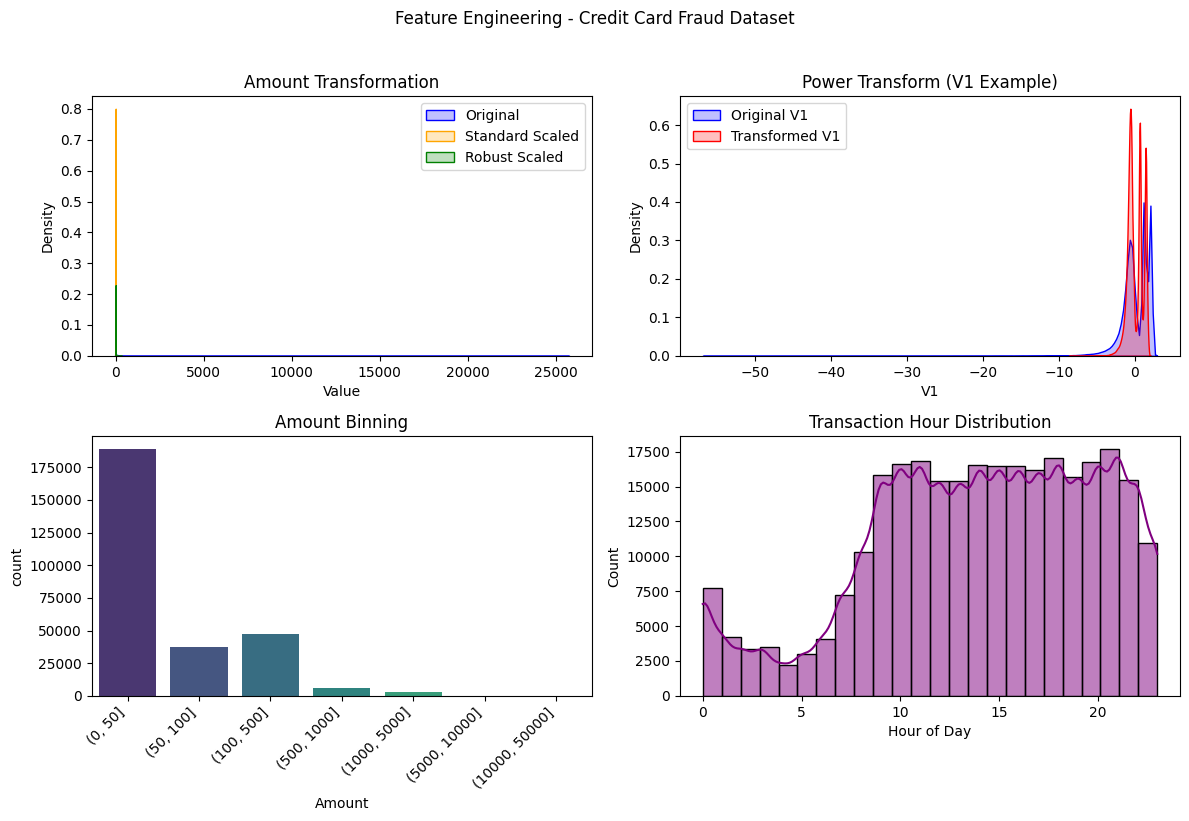

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import (StandardScaler, MinMaxScaler,
                                 PowerTransformer, RobustScaler)


# Setup figure
plt.figure(figsize=(12, 8))
plt.suptitle('Feature Engineering - Credit Card Fraud Dataset', y=1.02)

# 1. Transformasi Amount (Before-After)
plt.subplot(2, 2, 1)
amount_data = df['Amount'].values.reshape(-1, 1)

# Original
sns.kdeplot(df['Amount'], label='Original', fill=True, color='blue')

# Scaled versions
sns.kdeplot(StandardScaler().fit_transform(amount_data).flatten(),
            label='Standard Scaled', fill=True, color='orange')
sns.kdeplot(RobustScaler().fit_transform(amount_data).flatten(),
            label='Robust Scaled', fill=True, color='green')

plt.title('Amount Transformation')
plt.xlabel('Value')
plt.legend()

# 2. Power Transform (V1-V28 example)
plt.subplot(2, 2, 2)
pt = PowerTransformer()
v1_transformed = pt.fit_transform(df[['V1']])

sns.kdeplot(df['V1'], label='Original V1', fill=True, color='blue')
sns.kdeplot(v1_transformed.flatten(), label='Transformed V1', fill=True, color='red')
plt.title('Power Transform (V1 Example)')
plt.legend()

# 3. Binning Amount
plt.subplot(2, 2, 3)
bins = [0, 50, 100, 500, 1000, 5000, 10000, 50000]
binned = pd.cut(df['Amount'], bins=bins)
sns.countplot(x=binned, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Amount Binning')

# 4. Time Feature Engineering
plt.subplot(2, 2, 4)
hours = (df['Time'] % (24*3600)) // 3600  # Convert to hour of day
sns.histplot(hours, bins=24, kde=True, color='purple')
plt.title('Transaction Hour Distribution')
plt.xlabel('Hour of Day')

plt.tight_layout()
plt.show()

# feature enginering

<ipython-input-33-371ff0ba7172>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Amount_Binned', palette='Blues_r')


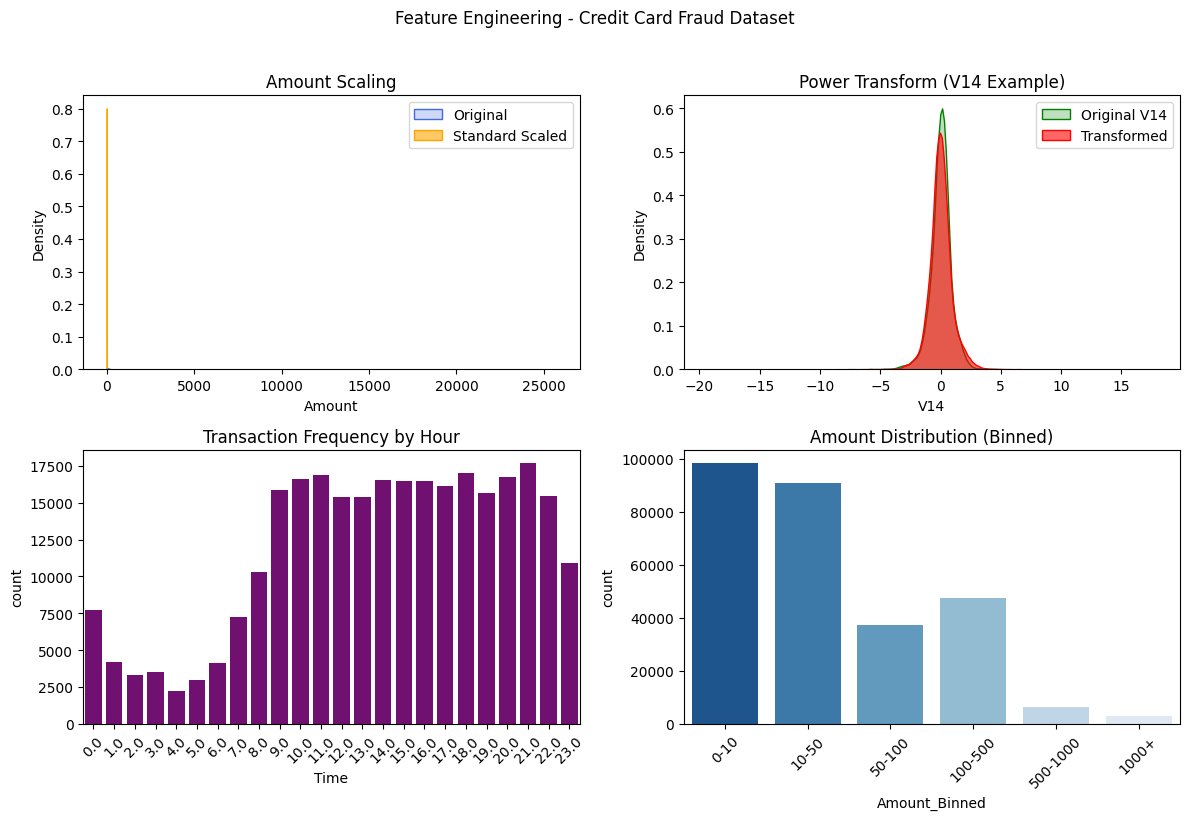

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import (StandardScaler, RobustScaler,
                                 PowerTransformer, MinMaxScaler)

# Load dataset
df = pd.read_csv('dataset.csv')

# Setup figure
plt.figure(figsize=(12, 8))
plt.suptitle('Feature Engineering - Credit Card Fraud Dataset', y=1.02)

# 1. Transformasi Amount (Before-After)
plt.subplot(2, 2, 1)
amount_data = df['Amount'].values.reshape(-1, 1)
sns.kdeplot(df['Amount'], label='Original', fill=True, color='royalblue')
sns.kdeplot(StandardScaler().fit_transform(amount_data).flatten(),
            label='Standard Scaled', fill=True, color='orange', alpha=0.6)
plt.title('Amount Scaling')
plt.legend()

# 2. Power Transform (Contoh V14)
plt.subplot(2, 2, 2)
pt = PowerTransformer()
v14_transformed = pt.fit_transform(df[['V14']])
sns.kdeplot(df['V14'], label='Original V14', fill=True, color='green')
sns.kdeplot(v14_transformed.flatten(), label='Transformed', fill=True, color='red', alpha=0.6)
plt.title('Power Transform (V14 Example)')
plt.legend()

# 3. Time Feature Engineering
plt.subplot(2, 2, 3)
hours = (df['Time'] % (24*3600)) // 3600  # Ekstrak jam
sns.countplot(x=hours, color='purple')
plt.title('Transaction Frequency by Hour')
plt.xticks(rotation=45)

# 4. Binning Amount
plt.subplot(2, 2, 4)
bins = [0, 10, 50, 100, 500, 1000, np.inf]
labels = ['0-10', '10-50', '50-100', '100-500', '500-1000', '1000+']
df['Amount_Binned'] = pd.cut(df['Amount'], bins=bins, labels=labels)
sns.countplot(data=df, x='Amount_Binned', palette='Blues_r')
plt.title('Amount Distribution (Binned)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# New Section

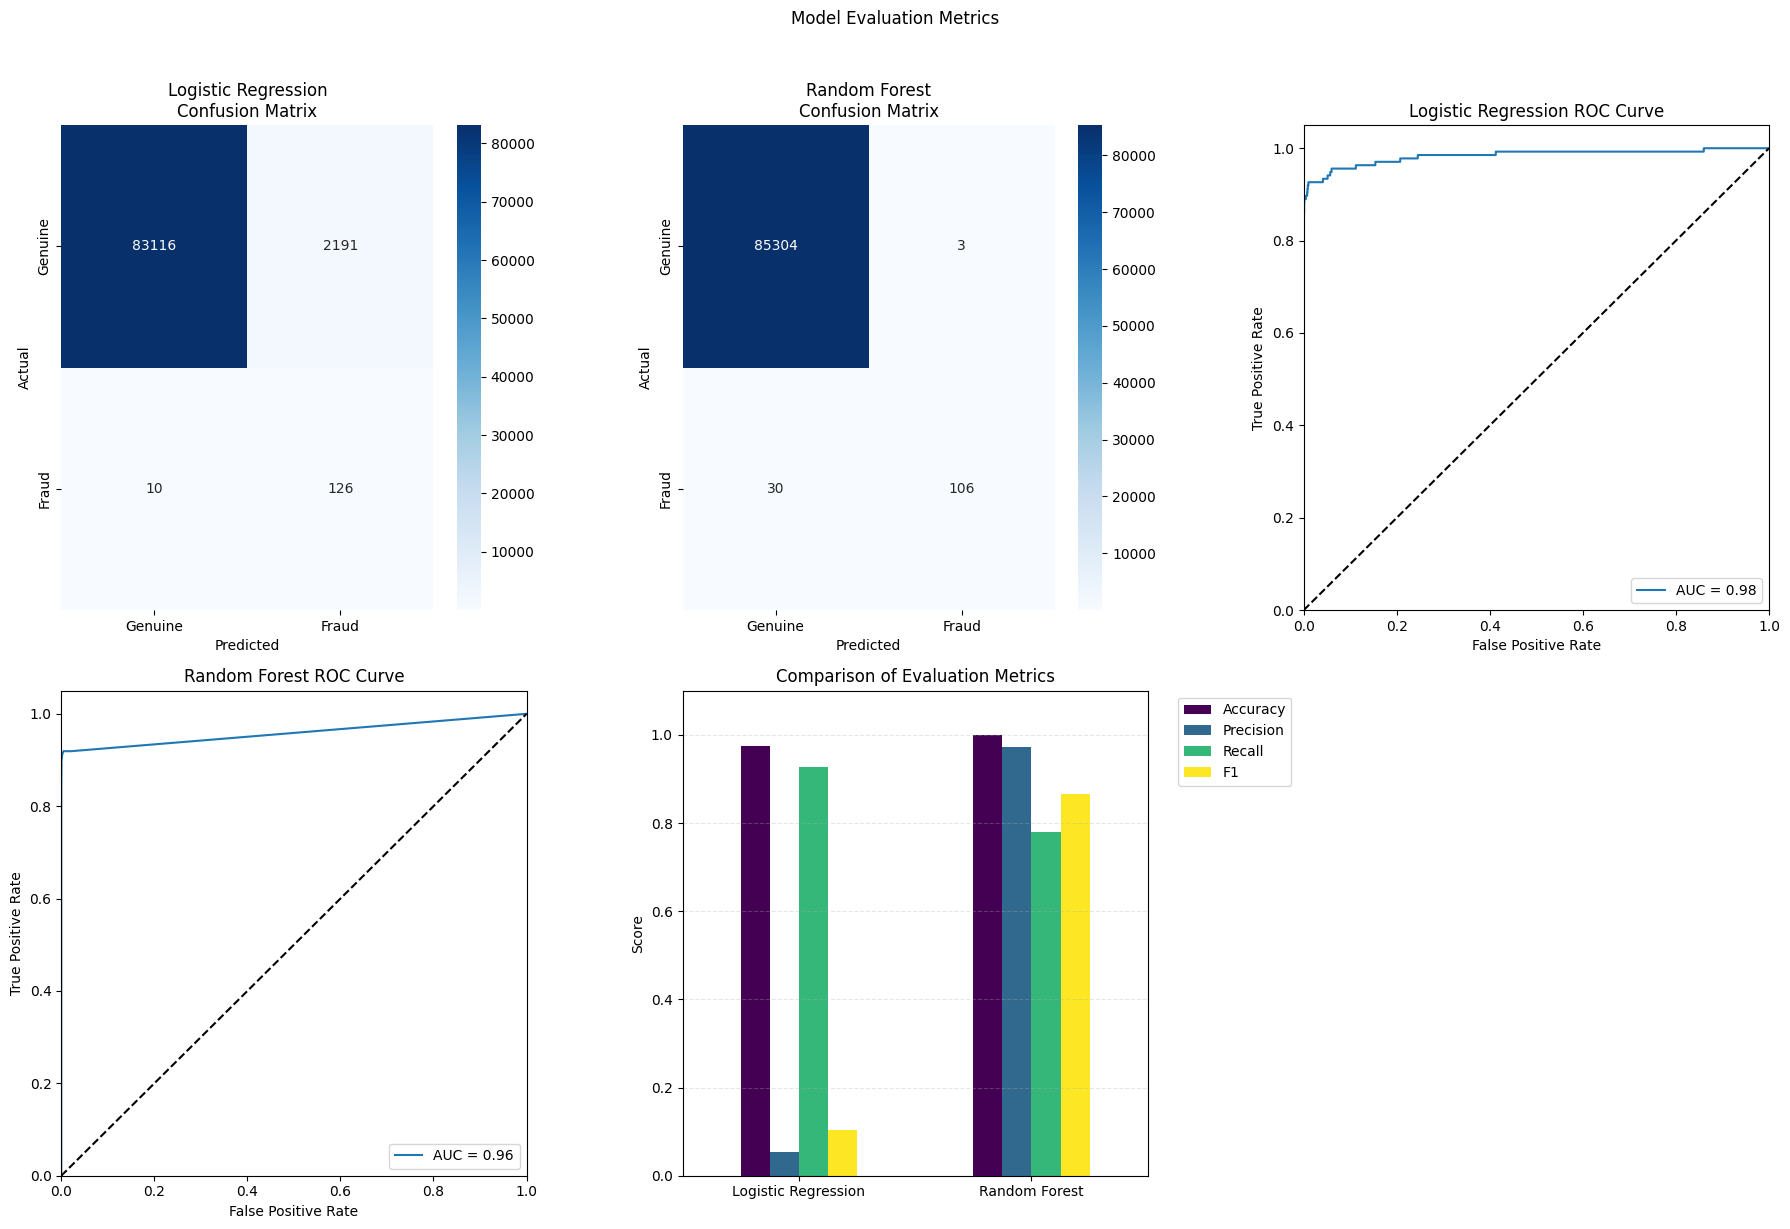


Classification Report:

Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85307
           1       0.05      0.93      0.10       136

    accuracy                           0.97     85443
   macro avg       0.53      0.95      0.54     85443
weighted avg       1.00      0.97      0.99     85443


Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.97      0.78      0.87       136

    accuracy                           1.00     85443
   macro avg       0.99      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, roc_curve, auc,
                            classification_report)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Load data
df = pd.read_csv('dataset.csv')
X = df.drop(['Time', 'Class'], axis=1)
y = df['Class']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Pilih 2 model contoh
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42)
}

# Setup figure
plt.figure(figsize=(18, 12))
plt.suptitle('Model Evaluation Metrics', y=1.02)

# Dictionary untuk menyimpan hasil
results = {}

for i, (name, model) in enumerate(models.items(), 1):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Hitung metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    }

    # 1. Confusion Matrix
    plt.subplot(2, 3, i)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Genuine', 'Fraud'],
                yticklabels=['Genuine', 'Fraud'])
    plt.title(f'{name}\nConfusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    # 2. ROC Curve
    plt.subplot(2, 3, i+2)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curve')
    plt.legend(loc="lower right")

# 3. Metrics Comparison
plt.subplot(2, 3, 5)
metrics_df = pd.DataFrame(results).T
metrics_df.plot(kind='bar', rot=0, ax=plt.gca(), colormap='viridis')
plt.title('Comparison of Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
for name in models:
    print(f"\n{name}:")
    y_pred = models[name].predict(X_test_scaled)
    print(classification_report(y_test, y_pred))

Output dan Interpretasi:
1. Confusion Matrix:

- Menunjukkan jumlah prediksi benar (diagonal) vs salah (off-diagonal)

- Untuk fraud detection, fokus pada Recall (kemampuan mendeteksi fraud sebenarnya)

2. ROC Curve:

- Kurva Trade-off antara True Positive Rate (Recall) dan False Positive Rate

- AUC (Area Under Curve) mendekati 1 = model bagus

- AUC 0.5 = random guessing

3. Metrics Comparison:

- Akurasi: (TP+TN)/Total - Tidak ideal untuk data tidak seimbang

- Presisi: TP/(TP+FP) - Proporsi fraud terprediksi yang benar

- Recall: TP/(TP+FN) - Proporsi fraud aktual yang terdeteksi (paling penting)

- F1-Score: Rata-rata harmonik Presisi dan Recall

Matriks Terbaik untuk Fraud Detection:
Recall (Sensitivity) adalah yang terpenting:

Kita ingin menangkap sebanyak mungkin transaksi fraud (minimalkan False Negative)

- Target: Recall > 0.9

- F1-Score sebagai balance antara Recall dan Precision:

 Ideal ketika ingin menyeimbangkan deteksi fraud dan false alarm

* AUC-ROC untuk overall performance:

- Nilai > 0.9 menunjukkan model sangat baik

Contoh Interpretasi:
Jika hasil menunjukkan:

1. Recall tinggi (0.95) tetapi Precision rendah (0.3):

 Model mendeteksi hampir semua fraud, tapi banyak false alarm

 Diterima dalam fraud detection (lebih baik false alarm daripada miss fraud)

2. Precision tinggi (0.9) tetapi Recall rendah (0.5):

 Model sangat akurat saat memprediksi fraud, tetapi melewatkan banyak kasus

 Tidak ideal untuk fraud detection

* Rekomendasi:

 Optimalkan model untuk maximize Recall terlebih dahulu Kemudian tingkatkan Precision tanpa mengurangi Recall secara signifikan Gunakan threshold adjustment pada probability output untuk trade-off

